In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
import matplotlib.image as mpimg
import json
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sympy import *
from datetime import datetime

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

month_names   = [x[:3] for x in calendar.month_name[1:13]]
month_names0  = np.roll(month_names,1)
slow_rate     = np.log(2)/30
K0            = 4

# Simulated equations

In [2]:
def daylen(phi,delta=23.44*np.pi/180):#23.44 degrees is earth tilt
    '''Computes fractional change in daylength as function of latitude'''
    return (2*(180/np.pi*np.arccos(np.tan(delta)*np.tan(phi*np.pi/180)))/15)

def GR_Resistance_fast(y,uapkr):
    ## timescale of minutes
    a1=0.17 #[1/min]
    a2=0.035 #[1/min]
    a3=0.0091 #[1/min]
    b1=a1;b2=a2;b3=a3

    u,A,P,k,R = uapkr
    [x1,x2,x3] = y 
    dy         = np.empty(3)
    
    dy[0] = u*b1/(x3*(1+(x3/k)**3))-a1*x1
    dy[1] = b2*x1*P/(1+(x3/k)**3)  -a2*x2
    dy[2] = b3*x2*A                -a3*x3/R
    return dy

def GetNumericSS_GR(U,A,P,K,R):
    t      = np.linspace(0,60*24,100)
    sol    = odeint(lambda y,t:GR_Resistance_fast(y,[U,A,P,K,R]),[1,1,1],t)
    res = sol[-1,:]
    return res

def simple_fast(y,uapk):
    ## timescale of minutes
    a1=0.17 #[1/min]
    a2=0.035 #[1/min]
    a3=0.0091 #[1/min]
    b1=a1;b2=a2;b3=a3

    u,A,P,k  = uapk
    [x1,x2,x3] = y 
    dy         = np.empty(3)

    dy[0] = u*b1/x3-a1*x1
    dy[1] = b2*x1*P-a2*x2
    dy[2] = b3*x2*A-a3*x3/R
    return dy

def GetNumericSS_simple(U,A,P,K):
    t      = np.linspace(0,60*24,100)
    sol    = odeint(lambda y,t:simple_fast(y,[U,A,P,K]),[1,1,1],t)
    res = sol[-1,:]
    return res

# Fit raw cortisol values for latitude/amplitude plot

In [3]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='raw'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]
    
    df.loc[df['month'] == 12,['month']] = 0
    
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp,np.pi,maxamp,np.pi)])
    
    A21         = res_fit[0]
    phi21       = res_fit[1]
    A22         = res_fit[2]
    phi22       = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)

    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        
        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))
        all_tests_acrophase  .append(get_acrophase(pars))
        all_tests_relmaxmin  .append(get_relmaxmin(pars))
        
        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 

        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
     
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    
    best_model = np.argmin(np.array([aic1,aic2,aic_null]))
        
    if best_model   == 0:
        return cosinor_tables[0]
    elif best_model == 1:
        return cosinor_tables[1]
    else:
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
        
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    
    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='raw'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='raw'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):

            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

Cortisol_Raw_fit  = gen_hormone_list({'CORTISOL_U_FREE_24h':'Cortisol-24h',
                                      'CORTISOL_BLOOD'     :'Cortisol'})

In [4]:
##################################################################
'''
obtained from: 
"Where in the world? Latitude, longitude and season contribute
to the complex co‐ordinates determining cortisol levels"
using the error over winter percentage change from summer  (range of +- 2SE)"
then dividing by 4 to get the size of 1SE
'''
AUSerr= np.array([5.38684342449727 - 3.19946527042832,
                9.05950095969289 - 4.31642445845900,
                13.9270679258164 - 10.7361474570486,
                14.1162376016940 - 10.1989301237045])/100/4
##################################################################
'''
obtained from: 
"Seasonal Variation in Human Salivary Cortisol Concentration."
Amplitude error is calculated by bootstrapping the by months 
'''
def bootstrap_maxmin(data,nboots=500):
    params=np.zeros(nboots)
    for i in range(nboots):
        inds=np.random.randint(0,12,12)
        rand_dat=data[inds]
        params[i]=(max(rand_dat)-min(rand_dat))/np.mean(rand_dat) 
    return np.mean(params),np.std(params)

f=open('../data/sweden.json','rb')
sweden_dat=json.load(f)['datasetColl'][0]['data']
sweden_dat=np.array([x['value'][1] for x in sweden_dat])
SWDerr=bootstrap_maxmin(sweden_dat)[1]/2
##################################################################
'''
Obtained from:"The CIRCORT database: Reference ranges and seasonal
changes in diurnal salivary cortisol derived from a meta-dataset
comprised of 15 field studies"
amplitude error avaiable in text
'''
UKerr =  2.2/100
##################################################################
'''
Obtained from:"Assessing cortisol from hair samples in a large observational cohort: The Whitehall II study"
Amplitude error is calculated by bootstrapping the by months 
'''
def bootstrap_maxmin8(data,nboots=500):
    params=np.zeros(nboots)
    for i in range(nboots):
        inds=np.random.randint(0,8,8)
        rand_dat=data[inds]
        uk_hair_bs_4_seas = [np.mean([rand_dat[7],rand_dat[0],rand_dat[1]]),#'winter'
                              np.mean([rand_dat[1],rand_dat[2],rand_dat[3]]),# 'spring'
                              np.mean([rand_dat[3],rand_dat[4],rand_dat[5]]),# 'summer'
                              np.mean([rand_dat[5],rand_dat[6],rand_dat[7]])]# 'autumn'
        params[i]=(max(uk_hair_bs_4_seas)-min(uk_hair_bs_4_seas))/np.mean(uk_hair_bs_4_seas) 
    return np.mean(params),np.std(params)

#uk hair seas :  'Winter ,Winter-spring,Spring,Spring-summer,Summer,Summer-autumn,Autumn,Autumn-winter'
uk_hair_dat        = np.array([4.21,3.26,2.78,3.25,3.42,3.49,3.83,3.86])
uk_hair_dat_4_seas = [np.mean([uk_hair_dat[7],uk_hair_dat[0],uk_hair_dat[1]]),#'winter'
                      np.mean([uk_hair_dat[1],uk_hair_dat[2],uk_hair_dat[3]]),# 'spring'
                      np.mean([uk_hair_dat[3],uk_hair_dat[4],uk_hair_dat[5]]),# 'summer'
                      np.mean([uk_hair_dat[5],uk_hair_dat[6],uk_hair_dat[7]])]# 'autumn'

UK_hair_amp = (np.max(uk_hair_dat_4_seas) - np.min(uk_hair_dat_4_seas))/np.mean(uk_hair_dat_4_seas)/2
UK_hair_err = bootstrap_maxmin8(uk_hair_dat)[1]/2

# calulate amplitude latitude 

In [ ]:
K0      = 4
k       = 66
PHIs    = np.arange(26,k,2)
amp_res = []
for phi in tqdm(PHIs):
    sim_time   = np.linspace(-21,3*365-1-21,3*365)
    adrenal    = np.zeros_like(sim_time)
    pituitary  = np.zeros_like(sim_time)

    adrenal[0] = 1; pituitary[0] = 1; 
    aP=slow_rate; aA=slow_rate; 
    bP=slow_rate; bA=slow_rate

    for i,t in enumerate(sim_time[:-1]): 
        A = adrenal[i]; P = pituitary[i]
        u          = 1 + 0.6*(1 - daylen(phi,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12)
        x1,x2,x3   = GetNumericSS_GR(u,A,P,K0,1)
        dA = A*(bA*x2-aA) #Adrenal cells
        dP = P*(bP*x1-aP) #Pituitary cells
        adrenal[i+1]   = A + dA
        pituitary[i+1] = P + dP

    adrenal   = adrenal[-365:] ; pituitary = pituitary[-365:]
    res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal,pituitary)])
    res = res/np.mean(res,axis=0)
    x3  = res[:,2]
    
    ## avergae over season to match the methodology of the stuides
    winter_cort = np.mean(x3[0:91])
    spring_cort = np.mean(x3[91:182])
    summer_cort = np.mean(x3[182:273])
    fall_cort   = np.mean(x3[273:])
    x3seas      = np.array([winter_cort,spring_cort,summer_cort,fall_cort])
    amp_res.append((x3seas.max()-x3seas.mean())/x3seas.mean())

pickle.dump([PHIs,amp_res],open('Theoretical_amplitude_latitude_0302.pickle','wb'))

In [57]:
def plot_latitudes(ax):
    import matplotlib.patheffects as path_effects

    df = pd.read_excel('../HP seasonality review.xlsx')
    df = df[['Place','SEX','Hormone','latitude','amplitude']].copy()
    df = df.loc[df['Hormone'] == 'Cortisol']
    df = df.dropna()
    df = df.drop(index =[33,34,6,0])

    df['error'] = np.nan
    df.loc[[1,2,3,4],['error']] = AUSerr
    df.loc[[5],['error']]       = UKerr
    df.loc[[35],['error']]      = SWDerr
    df.loc[[52],['error']]      = UK_hair_err
    df.loc[[5],['latitude']]    = 51.2
    df.loc[[52],['latitude']]   = 51.8
    df.loc[[5],['Place']]       = '   UK \n(Saliva)'
    df.loc[[52],['Place']]      = '  UK \n(Hair)'
    df.loc[[52],['amplitude']]  = UK_hair_amp

    ##### get sweden amplitude in 4 seasons ########
    f=open('../data/sweden.json','rb')
    sweden_dat=json.load(f)['datasetColl'][0]['data']
    sweden_dat=np.array([x['value'][1] for x in sweden_dat])
    winter_mean = np.mean(sweden_dat[[11,0,1]])
    spring_mean = np.mean(sweden_dat[[2,3,4]])
    summer_mean = np.mean(sweden_dat[[5,6,7]])
    fall_mean   = np.mean(sweden_dat[[8,9,10]])
    swedat = np.array([winter_mean,spring_mean,summer_mean,fall_mean])
    df.loc[[35],['amplitude']] = ((swedat.max() - swedat.min())/2)/(swedat.mean())
    ####################################################
    
    maxmin = Cortisol_Raw_fit['Cortisol-24h']['both']['Cosinor']['pars'][0][3]
    mesor  = np.mean(Cortisol_Raw_fit['Cortisol-24h']['both']['Clalit']['yloc'])
    err    = Cortisol_Raw_fit['Cortisol-24h']['both']['Cosinor']['pars'][1][3]
    df     = df.append({'Place':'  Israel \n(Urinary)','SEX':'both',
                        'Hormone':'Cortisol-24h','latitude':31.77,
                        'amplitude':maxmin/mesor,'error':err/mesor}
                       ,ignore_index=True)
    
    maxmin = Cortisol_Raw_fit['Cortisol']['both']['Cosinor']['pars'][0][3]
    mesor  = np.mean(Cortisol_Raw_fit['Cortisol']['both']['Clalit']['yloc'])
    err    = Cortisol_Raw_fit['Cortisol']['both']['Cosinor']['pars'][1][3]
    df     = df.append({'Place':'Israel (Serum)','SEX':'both',
                        'Hormone':'Cortisol','latitude':31.77,
                        'amplitude':maxmin/mesor,'error':err/mesor}
                       ,ignore_index=True)
    df['marker'] = np.nan
    df['marker'] = ['.','.','.','.','o','o','.','o','.']
#     display(df)
    e = ax.errorbar(np.abs(df['latitude'].values),df['amplitude'].values,df['error'],
                marker='o',ls='none',markersize=8,color=def_color[0],mec='k',capthick=4,elinewidth=2)
    e[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])

    ddf = df.loc[df['marker'] =='.']
    e = ax.errorbar(np.abs(ddf['latitude'].values),ddf['amplitude'].values,ddf['error'],
                marker='.',ls='none',markersize=8,color='white',ecolor=def_color[0],mec='k',capthick=4,elinewidth=2)
    e[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])

    ax.set_xlabel('|latitude|',fontsize=15,fontweight='bold')
    ax.set_ylabel('Relative amplitude',fontsize=15,fontweight='bold')

    locs =[[-1,-0.022],[1,-0.02],[-0.5,0.011],[0.5,-0.02],[1.5,-0.02],[-12,0.003],[-7.5,0.008],[-7.5,0.011],[0,-0.011]]
    
    for i,place in enumerate(df['Place']):
        if 'Aus' in place:
            place = place.replace('Australia','Aus')
        place = place.replace(',','\n')
        ax.annotate(place, (np.abs(df['latitude'].values)[i] + locs[i][0], df['amplitude'].values[i]+ locs[i][1]),fontsize=12)
    ax.tick_params(axis='y',labelsize =15)
    ax.tick_params(axis='x',labelsize =15)
    ax.set_yticks([0.05,0.1,0.15])
    ax.set_ylim([0.01,0.165])
#     ax.set_xlim([22,65])


# Plotting functions

In [15]:
def theory_3_subplot(axes,time, day_length, data1, data2, label1, label2, color1, color2):
    '''
    This function is used to plot effector and pituitary hormone together on a graph with two y-axes
    '''
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    
    ln1=ax1.plot(time,day_length,color=def_color[7],linewidth=3.0)
    ln2=ax2.plot(time,data1,linestyle='-',color=color1,linewidth=3.0)
    ln3=ax3.plot(time,data2,linestyle='-',color=color2,linewidth=3.0)
    
    ax1.tick_params(axis='y')
    ax1.set_ylabel('Day length [h]',fontsize=15,fontweight='bold')
    ax2.set_ylabel(label1,fontsize=15,fontweight='bold',color=color1)
    ax3.set_ylabel(label2,fontsize=15,fontweight='bold',color=color2)
    
    ax1.set_xlim([0,12])
    ax2.set_xlim([0,12])
    ax3.set_xlim([0,12])

    ax1.xaxis.set_visible(False)    
    ax2.xaxis.set_visible(False)    
    
    ax1.tick_params(axis='y',labelsize =15)
    ax1.set_yticks([]) 
    ax2.set_yticks([]) 
    ax3.set_yticks([]) 

    ax3.tick_params(axis='x',labelsize =15)
    
    
def HPA_graph1_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA1.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Constant \ngland mass'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.6),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')

    ax.annotate('Pituitary',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.5),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')
    
    ax.annotate('Adrenal',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.2),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

def HPA_graph2_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA2.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Gland mass \nnegative \nfeedback'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
    
    ax.annotate('Pituitary',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.5),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')
    
    ax.annotate('Adrenal',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.2),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')
    
def HPA_graph2b_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA2.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Gland mass \nnegative \nfeedback,' + '$K_GR$'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
    
def HPA_graph3_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA3.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Slow GR \nresistance'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.6),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
    
def HPA_graph4_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA4.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Cortisol reduces \nits own \nremoval rate'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')

    
def HPA_graph5_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA5.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'u controlling \nGR resistance'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
        
def HPA_graph6_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA6.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'u controlling \ncortisol \nremoval rate'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
        

# All simulations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


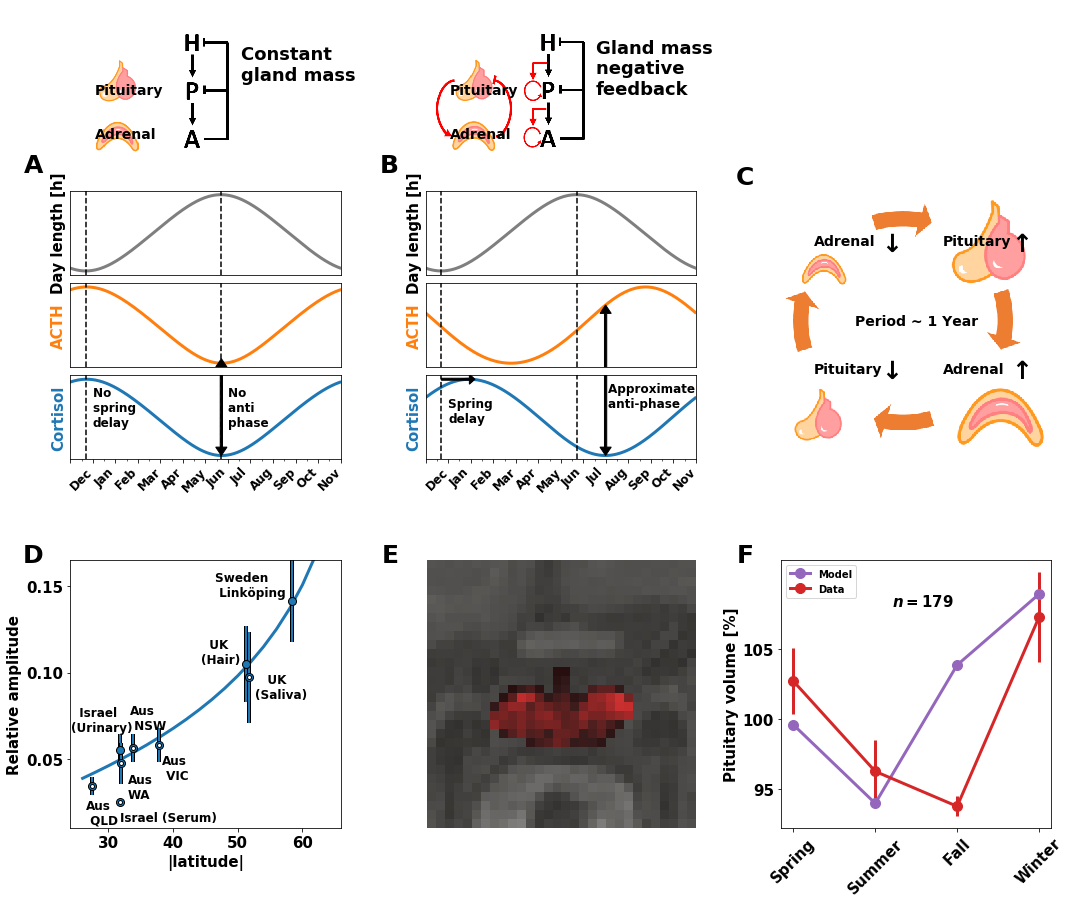

In [58]:
plt.rcParams["font.weight"] = "bold"
####################################################################
####################################################################
'''
FIG 3A -  Code to plot sesonality in a model without slow time scale
'''
####################################################################
####################################################################
fig = plt.figure(figsize=(15,13))
ax0 = plt.subplot2grid((10, 3), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((10, 3), (2, 0))
ax2 = plt.subplot2grid((10, 3), (3, 0))
ax3 = plt.subplot2grid((10, 3), (4, 0))
HPA_graph1_above_axe(ax0)
axes= [ax1,ax2,ax3]

ax0.text(-0.1, 0.1, 'A', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')

sim_time = np.linspace(-21,4*365-1-21,4*365)
K0 = 4,
res= []

for i,t in enumerate(sim_time[:-1]):
    u          = 2 - daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12
    x1,x2,x3   = GetNumericSS_GR(u,1,1,K0,1)
    res.append([x1,x2,x3])
res =np.array(res[-365:])
res = res/np.mean(res,axis=0)
x1  = res[:,0]; x2  = res[:,1]; x3  = res[:,2]
theory_3_subplot(axes,np.arange(365)/365*12,
                 [daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180) for t in sim_time[-365:]],
                 x2,x3,'ACTH','Cortisol',def_color[1],def_color[0])  

arrow_y_head = np.diff(ax2.get_ylim())[0]/10
ax2.arrow(12*x3.argmin()/365, ax2.get_ylim()[0],
          0, 0,
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

arrow_y_head = np.diff(ax3.get_ylim())[0]/10
ax3.arrow(12*x3.argmin()/365, ax3.get_ylim()[1],
          0, -(ax3.get_ylim()[1]-x3.min()-arrow_y_head),
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

ylim      = ax3.get_ylim()
anot_yloc = ylim[0] + np.diff(ylim)[0]*0.4

ax3.annotate('No \nanti \nphase',[7,anot_yloc],fontsize=12)
ax3.annotate('No \nspring \ndelay',[1,anot_yloc],fontsize=12)
ax1.axvline(x=0.7,ls='--',c='k')
ax2.axvline(x=0.7,ls='--',c='k')
ax3.axvline(x=0.7,ls='--',c='k')
ax1.axvline(x=6.7,ls='--',c='k')
ax2.axvline(x=6.7,ls='--',c='k')
ax3.axvline(x=6.7,ls='--',c='k')

ax3.set_xticks(np.arange(0,13,1))
ax3.set_xticklabels([])
ax3.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax3.set_xticklabels(month_names0[::1], rotation=45,fontsize=12,fontweight='bold',minor =True)

####################################################################
####################################################################
'''
FIG 3B -  Code to plot sesonality in a model with tissue turnover
'''
####################################################################
####################################################################
ax0 = plt.subplot2grid((10, 3), (0, 1), rowspan=2)
ax1 = plt.subplot2grid((10, 3), (2, 1))
ax2 = plt.subplot2grid((10, 3), (3, 1))
ax3 = plt.subplot2grid((10, 3), (4, 1))
HPA_graph2_above_axe(ax0)
axes= [ax1,ax2,ax3]

ax0.text(-0.1, 0.1, 'B', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')

sim_time = np.linspace(-21,4*365-1-21,4*365)
adrenal     = np.zeros_like(sim_time)
pituitary   = np.zeros_like(sim_time)
adrenal[0]  = 1; pituitary[0]= 1; K0 = 4
aP=slow_rate; aA=slow_rate; bP=slow_rate; bA=slow_rate
aP=slow_rate; aA=slow_rate; bP=slow_rate; bA=slow_rate

for i,t in enumerate(sim_time[:-1]): 
    A = adrenal[i]; P = pituitary[i]
    u          = 2 - daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12
    x1,x2,x3   = GetNumericSS_GR(u,A,P,K0,1)
    dA = A*(bA*x2-aA) #Adrenal cells
    dP = P*(bP*x1-aP) #Pituitary cells
    adrenal[i+1]   = A + dA
    pituitary[i+1] = P + dP
    
adrenal   = adrenal[-365:] ; pituitary = pituitary[-365:]

res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal,pituitary)])
res = res/np.mean(res,axis=0)
x1  = res[:,0]; x2  = res[:,1]; x3  = res[:,2]
theory_3_subplot(axes,np.arange(365)/365*12,
                 [daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180) for t in sim_time[-365:]],
                 x2,x3,'ACTH','Cortisol',def_color[1],def_color[0]) 

arrow_y_head = np.diff(ax2.get_ylim())[0]/10
ax2.arrow(12*x3.argmin()/365, ax2.get_ylim()[0]-arrow_y_head,
          0, x2[x3.argmin()]-ax2.get_ylim()[0],
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

arrow_y_head = np.diff(ax3.get_ylim())[0]/10
ax3.arrow(12*x3.argmin()/365, ax3.get_ylim()[1],
          0, -(ax3.get_ylim()[1]-x3.min()-arrow_y_head),
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

ylim      = ax3.get_ylim()
anot_yloc = ylim[0] + np.diff(ylim)[0]*0.44
ax3.annotate('Approximate \nanti-phase \n ',[8.1,anot_yloc],fontsize=12)
ax3.annotate('\nSpring \ndelay',[1,anot_yloc],fontsize=12)
ax3.arrow(0.7, x3.max(), 12*x3.argmax()/365-0.7, 0,width=0.005, head_width=0.025, head_length=0.25, fc='k', ec='k', zorder=4)
ax1.axvline(x=0.7,ls='--',c='k'); ax1.axvline(x=6.7,ls='--',c='k')
ax2.axvline(x=0.7,ls='--',c='k'); ax2.axvline(x=6.7,ls='--',c='k')
ax3.axvline(x=0.7,ls='--',c='k'); ax3.axvline(x=6.7,ls='--',c='k')

ax3.set_xticks(np.arange(0,13,1))
ax3.set_xticklabels([])
ax3.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax3.set_xticklabels(month_names0[::1], rotation=45,fontsize=12,fontweight='bold',minor =True)
##########################################################
##########################################################
'''
FIG 3C -  Code to plot circannual oscilator image
'''
##########################################################
##########################################################
img = plt.imread('../figures/ppt/HPA_oscilator.PNG')

ax0 = plt.subplot2grid((10, 3), (0, 2), rowspan=2)
ax0.text(-0.1, 0.1, 'C', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')

ax = plt.subplot2grid((10, 3), (2, 2), rowspan=3)
ax.imshow(img)
ax.axis('off')

ax.annotate('Pituitary',fontsize=14,fontweight='bold',
            xytext=(0.12,0.32),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('↓',fontsize=25,fontweight='bold',
            xytext=(0.37,0.30),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Pituitary',fontsize=14,fontweight='bold',
            xytext=(0.6,0.8),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('↑',fontsize=25,fontweight='bold',
            xytext=(0.85,0.78),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Adrenal',fontsize=14,fontweight='bold',
            xytext=(0.6,0.32),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('↑',fontsize=25,fontweight='bold',
            xytext=(0.85,0.30),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Adrenal',fontsize=14,fontweight='bold',
            xytext=(0.12,0.8),xy=(0,0),
            
            xycoords='axes fraction',textcoords='axes fraction')
ax.annotate('↓',fontsize=25,fontweight='bold',
            xytext=(0.37,0.78),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Period ~ 1 Year',fontsize=14,fontweight='bold',
            xytext=(0.275,0.5),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

##########################################################
##########################################################
'''
FIG 3E -  Code to show pituitary segmentation image 
'''
##########################################################
##########################################################
img,mask = pickle.load(open('D:/Alon/AlonProjects/HPA/HPA-master/HPA-master/figures/pituitray_seg_mat.pickle','rb'))
ax0 = plt.subplot2grid((10, 3), (5, 1), rowspan=1)
ax0.text(-0.1, 0.1, 'E', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')
img  = img[20:50,20:50,40]
mask = mask[20:50,20:50,40]
mask2 = mask*img
im = np.dstack((mask2,np.zeros_like(mask2),np.zeros_like(mask2)))

ax = plt.subplot2grid((10, 3), (6, 1), rowspan=3)
ax.imshow(img, cmap='gray')
ax.imshow(mask,alpha=0.4,cmap ='OrRd')
ax.imshow(im,alpha=0.5,cmap ='OrRd')
ax.axis('off')
##########################################################
##########################################################
'''
FIG 3F -  Code to plot pituitary seasonality
'''
##########################################################
##########################################################
ax0 = plt.subplot2grid((10, 3), (5, 2), rowspan=1)
ax0.text(-0.1, 0.1, 'F', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')
ax = plt.subplot2grid((10, 3), (6, 2), rowspan=3)

pituitary_table = pd.read_excel('../data/Pituitary_HCP.xlsx')
norm_mean   = np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))
norm_std    = np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))

winter_mean = np.mean(norm_mean[[11,0,1]])
winter_std  = np.std(norm_std[[11,0,1]])/3**0.5

spring_mean = np.mean(norm_mean[[2,3,4]])
spring_std  = np.std(norm_std[[2,3,4]])/3**0.5

summer_mean = np.mean(norm_mean[[5,6,7]])
summer_std  = np.std(norm_std[[5,6,7]])/3**0.5

fall_mean   = np.mean(norm_mean[[8,9,10]])
fall_std    = np.std(norm_std[[8,9,10]])/3**0.5

season_mean = 100*np.array([spring_mean,summer_mean,fall_mean,winter_mean])
season_std  = 100*np.array([spring_std,summer_std,fall_std,winter_std])

ax.errorbar([0,1,2,3],season_mean,yerr=season_std,marker='.',color=def_color[3],markersize=20,linewidth=3)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Spring','Summer','Fall','Winter'], rotation=45)

ax.set_yticks([95,100,105])
ax.set_ylabel('Pituitary volume [%]',fontsize=15,fontweight='bold')
ax.annotate('$n=179$',(1.2,108),fontsize=15)

winter_pit = np.mean(pituitary[0:91])
spring_pit = np.mean(pituitary[91:182])
summer_pit = np.mean(pituitary[182:273])
fall_pit   = np.mean(pituitary[273:])

season_pit = 100*np.array([spring_pit,summer_pit,fall_pit,winter_pit])
ax.plot([0,1,2,3],season_pit,marker='.',color=def_color[4],markersize=20,linewidth=3)
ax.legend(['Model','Data'])
ax.tick_params(axis='y',labelsize =15)
ax.tick_params(axis='x',labelsize =15)

##########################################################
##########################################################
'''
FIG 3D -  Code to plot amplitude/lattitude plot
'''
##########################################################
##########################################################
ax0 = plt.subplot2grid((10, 3), (5, 0), rowspan=1)
ax0.text(-0.1, 0.1, 'D', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')
ax = plt.subplot2grid((10, 3), (6, 0), rowspan=3)
plot_latitudes(ax)

[PHIs,amp_res] = pickle.load(open('Theoretical_amplitude_latitude_0302.pickle','rb'))
ax.plot(PHIs,np.array(amp_res),lw=3,c=def_color[0],zorder=-1)

##########################################################
##########################################################
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.savefig('../figures/Seasonality11022020/Figure3_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()

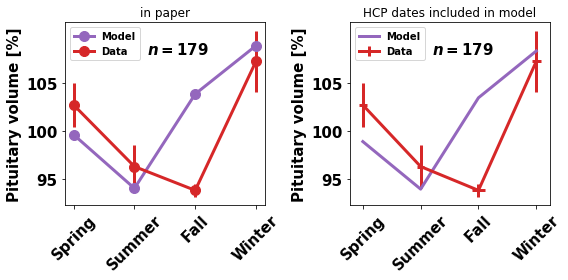

In [178]:
'''
FIG 3F -  Code to plot pituitary seasonality
'''
fig = plt.figure(figsize=(8,4))
pituitary_table = pd.read_excel('../data/Pituitary_HCP.xlsx')
norm_mean   = np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))
norm_std    = np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))

winter_mean = np.mean(norm_mean[[11,0,1]])
winter_std  = np.std(norm_std[[11,0,1]])/3**0.5

spring_mean = np.mean(norm_mean[[2,3,4]])
spring_std  = np.std(norm_std[[2,3,4]])/3**0.5

summer_mean = np.mean(norm_mean[[5,6,7]])
summer_std  = np.std(norm_std[[5,6,7]])/3**0.5

fall_mean   = np.mean(norm_mean[[8,9,10]])
fall_std    = np.std(norm_std[[8,9,10]])/3**0.5

season_mean = 100*np.array([spring_mean,summer_mean,fall_mean,winter_mean])
season_std  = 100*np.array([spring_std,summer_std,fall_std,winter_std])
ax = plt.subplot(121)
ax.errorbar([0,1,2,3],season_mean,yerr=season_std,marker='.',color=def_color[3],markersize=20,linewidth=3)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Spring','Summer','Fall','Winter'], rotation=45)

ax.set_yticks([95,100,105])
ax.set_ylabel('Pituitary volume [%]',fontsize=15,fontweight='bold')
ax.annotate('$n=179$',(1.2,108),fontsize=15)

winter_pit = np.mean(pituitary[0:91])
spring_pit = np.mean(pituitary[91:182])
summer_pit = np.mean(pituitary[182:273])
fall_pit   = np.mean(pituitary[273:])

season_pit = 100*np.array([spring_pit,summer_pit,fall_pit,winter_pit])
ax.plot([0,1,2,3],season_pit,marker='.',color=def_color[4],markersize=20,linewidth=3)
ax.legend(['Model','Data'])
ax.tick_params(axis='y',labelsize =15)
ax.tick_params(axis='x',labelsize =15)
ax.set_title('in paper')
'''
 Code to plot pituitary seasonality, by HCP date distribution
'''
pituitary_dates = pd.read_excel('../data/hcp_dates.xlsx',header =None)
dates = []
for i in range(len(pituitary_dates)):
    if i ==0:
        dates.append(pituitary_dates.iloc[i][0][:-1])
    else:
        dates.append(pituitary_dates.iloc[i][0][1:-1])
dates   = [datetime.strptime(date, '%m/%d/%Y') for date in dates]
months  = np.array([date.month for date in dates])
d_jan_1 = np.array([(date - datetime(date.year, 1, 1)).days for date in dates])

winter = (months ==  12) | (months ==  1) | (months ==  2) 
spring =  (months ==  3) | (months ==  4) | (months ==  5) 
summer =  (months ==  6) | (months ==  7) | (months ==  8) 
fall   =  (months ==  9) | (months ==  10) | (months ==  1) 

pituitary_table = pd.read_excel('../data/Pituitary_HCP.xlsx')
norm_mean   = np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))
norm_std    = np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))

winter_mean = np.mean(norm_mean[[11,0,1]])
winter_err  = np.std(norm_std[[11,0,1]])/3**0.5
err_days    = circstd(d_jan_1[winter],high=365,low=0)/np.sqrt(sum(winter))
winter_xerr = err_days/90

spring_mean = np.mean(norm_mean[[2,3,4]])
spring_err  = np.std(norm_std[[2,3,4]])/3**0.5
err_days    = circstd(d_jan_1[spring],high=365,low=0)/np.sqrt(sum(winter))
spring_xerr = err_days/90

summer_mean = np.mean(norm_mean[[5,6,7]])
summer_err  = np.std(norm_std[[5,6,7]])/3**0.5
err_days    = circstd(d_jan_1[summer],high=365,low=0)/np.sqrt(sum(winter))
summer_xerr = err_days/90

fall_mean   = np.mean(norm_mean[[8,9,10]])
fall_err    = np.std(norm_std[[8,9,10]])/3**0.5
err_days    = circstd(d_jan_1[fall],high=365,low=0)/np.sqrt(sum(winter))
fall_xerr   = err_days/90

season_mean = 100*np.array([spring_mean,summer_mean,fall_mean,winter_mean])
season_err  = 100*np.array([spring_err,summer_err,fall_err,winter_err])
season_x_err= [spring_xerr,summer_xerr,fall_xerr,winter_xerr]

ax = plt.subplot(122)
ax.errorbar([0,1,2,3],season_mean,yerr=season_err,xerr=season_x_err, marker='.',color=def_color[3],markersize=0,linewidth=3)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Spring','Summer','Fall','Winter'], rotation=45)

ax.set_yticks([95,100,105])
ax.set_ylabel('Pituitary volume [%]',fontsize=15,fontweight='bold')
ax.annotate('$n=179$',(1.2,108),fontsize=15)

d_dec_1 = d_jan_1 +30
d_dec_1[d_dec_1>365] = d_dec_1[d_dec_1>365] -365

winter_pit = np.mean(pituitary[d_dec_1[winter]])
spring_pit = np.mean(pituitary[d_dec_1[spring]])
summer_pit = np.mean(pituitary[d_dec_1[summer]])
fall_pit   = np.mean(pituitary[d_dec_1[fall]])

season_pit = 100*np.array([spring_pit,summer_pit,fall_pit,winter_pit])
ax.plot([0,1,2,3],season_pit,marker='.',color=def_color[4],markersize=0,linewidth=3)
ax.legend(['Model','Data'])
ax.tick_params(axis='y',labelsize =15)
ax.tick_params(axis='x',labelsize =15)
ax.set_title('HCP dates included in model')
plt.tight_layout()

D:\Anaconda\envs\venv\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


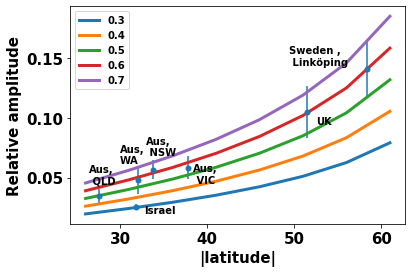

In [24]:
F_list = [0.3,0.4,0.5,0.6,0.7]
for j,F in tqdm(enumerate(F_list)):
    K0      = 4
    k       = 66
    PHIs    = np.arange(26,k,5)
    amp_res = []
    for phi in tqdm(PHIs):
        sim_time   = np.linspace(-21,3*365-1-21,3*365)
        adrenal    = np.zeros_like(sim_time)
        pituitary  = np.zeros_like(sim_time)
        adrenal[0] = 1; pituitary[0] = 1; 
        aP=slow_rate; aA=slow_rate; 
        bP=slow_rate; bA=slow_rate

        for i,t in enumerate(sim_time[:-1]): 
            A = adrenal[i]; P = pituitary[i]
            u          = 1 + F*(1 - daylen(phi,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12)
            x1,x2,x3   = GetNumericSS_GR(u,A,P,K0,1)
            dA = A*(bA*x2-aA) #Adrenal cells
            dP = P*(bP*x1-aP) #Pituitary cells
            adrenal[i+1]   = A + dA
            pituitary[i+1] = P + dP

        adrenal   = adrenal[-365:]; pituitary = pituitary[-365:];
        res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal,pituitary)])
        res = res/np.mean(res,axis=0)
        x3  = res[:,2]

        ## avergae over season to match the methodology of the stuides
        winter_cort = np.mean(x3[0:91])
        spring_cort = np.mean(x3[91:182])
        summer_cort = np.mean(x3[182:273])
        fall_cort   = np.mean(x3[273:])
        x3seas      = np.array([winter_cort,spring_cort,summer_cort,fall_cort])
        amp_res.append((x3seas.max()-x3seas.mean())/x3seas.mean())

    ax = plt.subplot(1,1,1)
    ax.plot(PHIs,np.array(amp_res),lw=3,c=def_color[j])
    ax.tick_params(axis='y',labelsize =15)
    ax.tick_params(axis='x',labelsize =15)
    ax.set_yticks([0.05,0.1,0.15])    
plot_latitudes(ax) 
plt.legend([str(f) for f in F_list])
plt.show()